function to compute numpy representation from video file (thanks Yana!)

In [1]:
import numpy as np
import cv2

# trs, let's assume width is always wider than height
def video_to_npy(infile, outfile=None, width=None, height=None, squarecrop=None, fps=None, cropat=None):
    print('reading video from %s' % infile)
    vidcap = cv2.VideoCapture(infile)
    success, image = vidcap.read()
    
    frames = []
    count = 0
    if not success:
        raise ValueError('Could not read the video file!')
    while success:
        frames.append( image[...,::-1] )
        count += 1
        success,image = vidcap.read()
    if fps:
        span = int(vidcap.get(cv2.CAP_PROP_FPS) / fps)
        frames = frames[0::span] 
    if width or height:  
        width = width if width else int(height / frames[0].shape[0] * frames[0].shape[1])
        height = height if height else int(width / frames[0].shape[1] * frames[0].shape[0])
        frames = [ cv2.resize(frame, (width, height)) for frame in frames ]
    if squarecrop:
        tl = int((width/2)-(height/2))
        # note that x,y is the wrong way around i.e. it's
        # F x Y x X x C
        frames = [ frame[ 0:height, tl:(tl+height)] for frame in frames ]
    if cropat:
        frames = frames[0:cropat*fps]
        
        
    frames = np.array(frames)
    if outfile:
        np.save(outfile, frames)
    return frames

for every video in the collisions/non collisions folder, compute the numpy representation 

In [38]:
from os import listdir
from os.path import isfile, join
from itertools import *
from pipe import *

# return iterable { (label, path/video1), (label, path/video2), ... }
def GetVideos( path, label, ext='.mp4' ):
    p = listdir(path) | where( lambda p: p.endswith(ext) ) | as_list()
    return zip( repeat(label, len(p)), map( lambda p: join( path, p ), p ) )

videos = GetVideos('./train/collisions', 1) \
            | chain_with( GetVideos('./val/not-collisions', 0) ) \
            | chain_with( GetVideos('./train/not-collisions', 0) ) \
            | chain_with( GetVideos('./val/collisions', 1) )

# which ones do not have a numpy representation computed yet? i.e. no .npy file present
to_process = videos \
                | where( lambda f: not isfile( f[1].replace('.mp4','.npy') ) )

framerate = 25
video_size = 300
max_length = 5

# adorn the video to the tuple iterator, return cloned+appended tuple
def adornVideo(iterator):
    return iterator \
        | select( lambda f: f + ( 
            video_to_npy( f[1], 
                         #note weird thing here, width doesn't work they appear to be inverted
                         height=video_size, 
                         squarecrop=True, 
                         fps=framerate,
                         cropat=max_length
            ), ) )

to_process_withvideo = adornVideo( to_process )
videos_withvideo =  adornVideo( videos )


In [3]:
v = videos_withvideo | take(5) | select(lambda v: v[2].shape) |  as_list()

print(v)

# some assertions, apparently we are not getting the video size we require
for shape in v:
    assert( shape[2]==video_size and shape[1]==video_size )

reading video from ./train/collisions\output002-27378.mp4
reading video from ./train/collisions\output005-26961.mp4
reading video from ./train/collisions\output006.mp4
reading video from ./train/collisions\output009-26961.mp4
reading video from ./train/collisions\output009-5404.mp4
reading video from ./train/collisions\output009.mp4
[(125, 300, 300, 3), (39, 300, 300, 3), (95, 300, 300, 3), (83, 300, 300, 3), (125, 300, 300, 3)]


In [4]:
# write these npy files out to the file system in the respective location
for v in to_process_withvideo:
    print( 'saved %s (class %d)' % ( v[1], v[0] ) )
    np.save(v[1].replace('.mp4','.npy'), v[2])

reading video from ./train/not-collisions\output023-26961.mp4
saved ./train/not-collisions\output023-26961.mp4 (class 0)
reading video from ./train/not-collisions\output023.mp4
saved ./train/not-collisions\output023.mp4 (class 0)
reading video from ./train/not-collisions\output026-26961.mp4
saved ./train/not-collisions\output026-26961.mp4 (class 0)
reading video from ./train/not-collisions\output026-5404.mp4
saved ./train/not-collisions\output026-5404.mp4 (class 0)
reading video from ./train/not-collisions\output026.mp4
saved ./train/not-collisions\output026.mp4 (class 0)
reading video from ./train/not-collisions\output028-5404.mp4
saved ./train/not-collisions\output028-5404.mp4 (class 0)
reading video from ./train/not-collisions\output029-5404.mp4
saved ./train/not-collisions\output029-5404.mp4 (class 0)
reading video from ./train/not-collisions\output029.mp4
saved ./train/not-collisions\output029.mp4 (class 0)
reading video from ./train/not-collisions\output031.mp4
saved ./train/not-

saved ./train/not-collisions\output121.mp4 (class 0)
reading video from ./train/not-collisions\output124.mp4
saved ./train/not-collisions\output124.mp4 (class 0)
reading video from ./train/not-collisions\output134.mp4
saved ./train/not-collisions\output134.mp4 (class 0)
reading video from ./train/not-collisions\output135.mp4
saved ./train/not-collisions\output135.mp4 (class 0)
reading video from ./val/collisions\output000-26961.mp4
saved ./val/collisions\output000-26961.mp4 (class 1)
reading video from ./val/collisions\output000.mp4
saved ./val/collisions\output000.mp4 (class 1)
reading video from ./val/collisions\output001.mp4
saved ./val/collisions\output001.mp4 (class 1)
reading video from ./val/collisions\output002.mp4
saved ./val/collisions\output002.mp4 (class 1)
reading video from ./val/collisions\output003-27378.mp4
saved ./val/collisions\output003-27378.mp4 (class 1)
reading video from ./val/collisions\output003-5404.mp4
saved ./val/collisions\output003-5404.mp4 (class 1)
read

In [9]:
@Pipe
def pshuffle(l):
    shuffle(l)
    return l
@Pipe
def pcycle(l):
    return cycle(l)

ok, so at this point we now have a numpy array for every single video file! the numpy arrays are fixed on some video size, length and frame rate i.e. 200^2, 5 seconds and 25fps.  

For every single video file, we compute a random augmentation consistently across all of the frames

In [13]:
import random
from random import shuffle
from keras.preprocessing.image import ImageDataGenerator

data_gen_args = dict(featurewise_center=False,
                     featurewise_std_normalization=False,
                     rotation_range=10,
                     width_shift_range=0.1,
                     height_shift_range=0.1,
                     zoom_range=0.2,
                     horizontal_flip=True)

image_datagen = ImageDataGenerator(**data_gen_args)

def videoFlowWithAugmentation( 
    colpath='./collisions',
    noncolpath='./not-collisions',
    augment=True, 
    diff=False,
    normalize=True):
    
    # get a shuffled infinite sequence of training videos
    videos = GetVideos(colpath, label=1, ext='.npy') \
        | chain_with( GetVideos(noncolpath, label=0, ext='.npy') ) \
        | as_list() \
        | pshuffle() \
        | pcycle()

    # clever stuff here, the actual video will be loaded lazily
    videos_withdata = videos \
        | select( lambda f: f + ( np.load(f[1]) ,) )

    for video in videos_withdata:
        # for every frame in this video generate the same transformation
        # and yield it all back in sequence order
        trans = image_datagen.get_random_transform(video[2].shape)
        augmentedVideo = np.zeros( video[2].shape )
        for i in range(video[2].shape[0]):
            if augment:
                augmentedVideo[i] = image_datagen.apply_transform(video[2][i], trans)
            else:
                augmentedVideo[i] = video[2][i]
            
            # now is a good time to transform the video onto 0-1
            # we need to do this to get convergence when we train i.e. homogenise features
            if normalize:
                augmentedVideo[i] = augmentedVideo[i]
            
            # take xth order differences of frames to convey pixel-wise temporal changes
            if diff is not None:
                augmentedVideo[i, 0:augmentedVideo[i].shape[0]-diff] = np.diff(augmentedVideo[i], axis=0, n=diff)
            
        yield video[:-1] + (augmentedVideo.astype(np.int32),)
            
train_flow = videoFlowWithAugmentation(colpath='./train/collisions',noncolpath='./train/not-collisions', diff=None, augment=True)
# remember, on validation we don't want to augment anything!
val_flow = videoFlowWithAugmentation(colpath='./val/collisions',noncolpath='./val/not-collisions', augment=False)

let's visualize the augmented results for this video

In [7]:
import matplotlib.pyplot as plt

def show_images(images, cols = 1, titles = None):
    assert((titles is None)or (len(images) == len(titles)))
    n_images = len(images)
    if titles is None: titles = ['Image (%d)' % i for i in range(1,n_images + 1)]
    fig = plt.figure()
    for n, (image, title) in enumerate(zip(images, titles)):
        a = fig.add_subplot(cols, np.ceil(n_images/float(cols)), n + 1)
        if image.ndim == 2:
            plt.gray()
        plt.imshow(image)
        a.set_title(title)
        plt.xticks([]), plt.yticks([])
    fig.set_size_inches(np.array(fig.get_size_inches()) * n_images)
    plt.tight_layout()
    plt.show()
    display()

(125, 300, 300, 3)
(110, 300, 300, 3)
(72, 300, 300, 3)


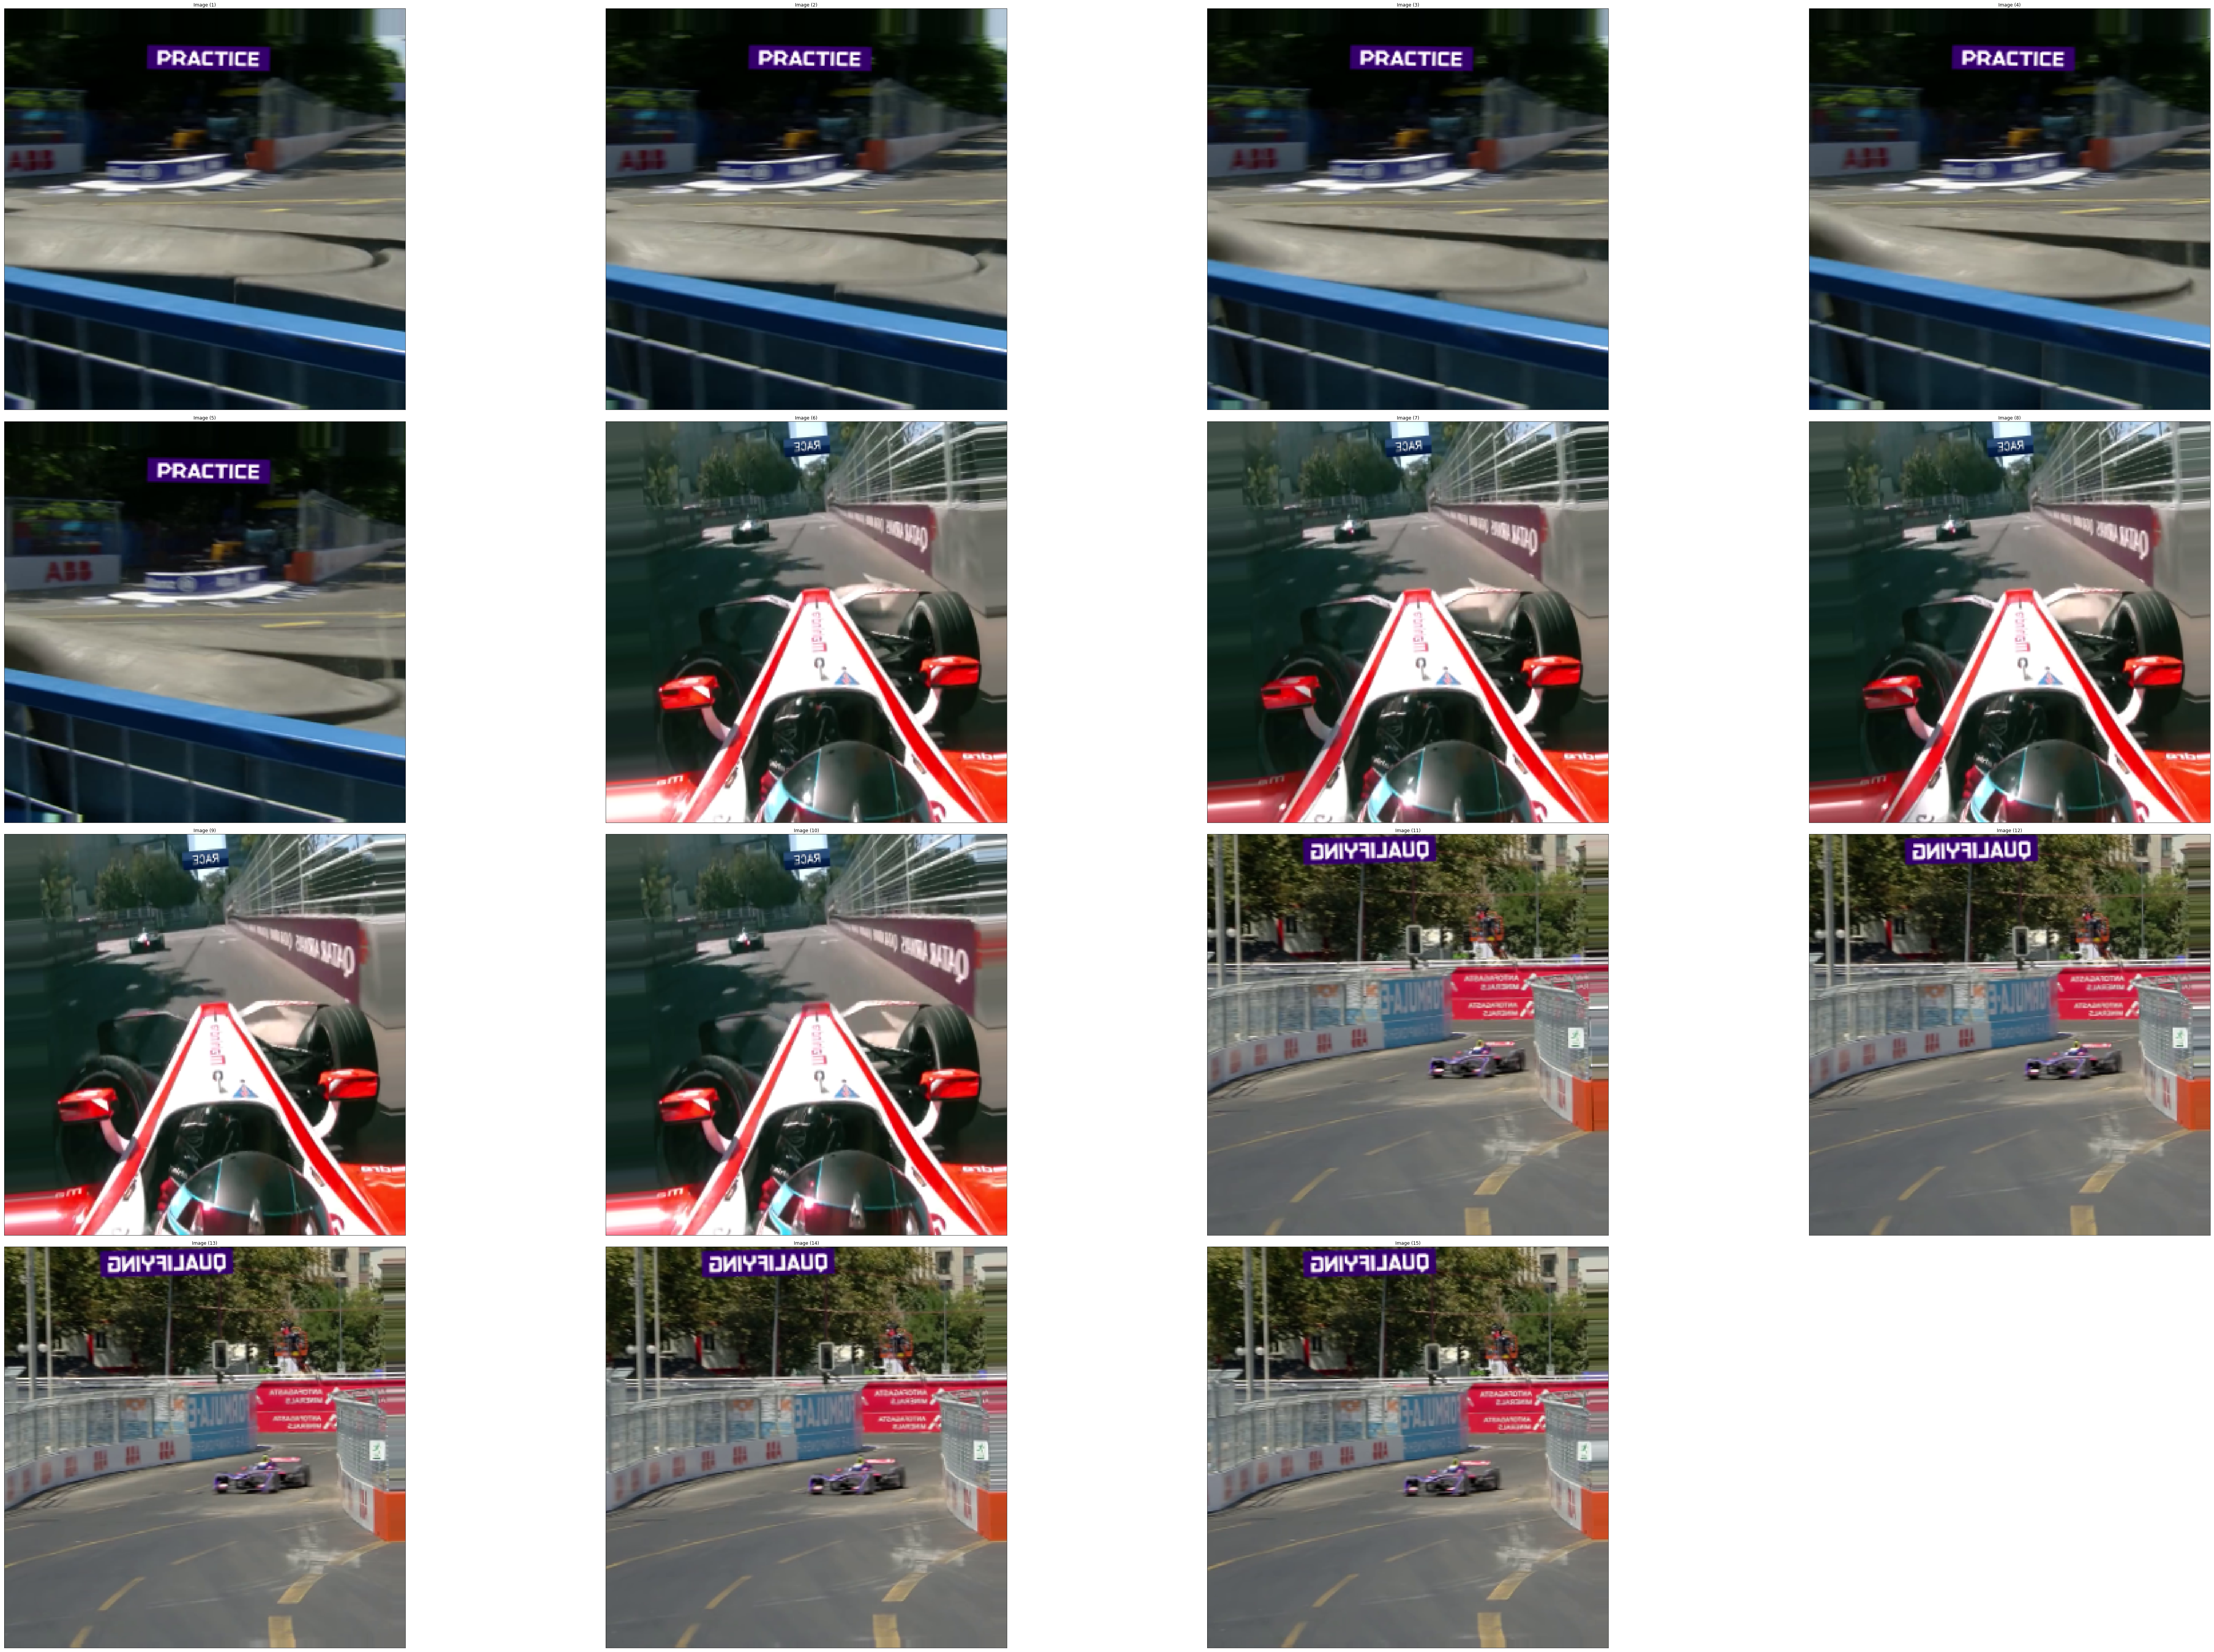

(51, 300, 300, 3)
(125, 300, 300, 3)
(87, 300, 300, 3)


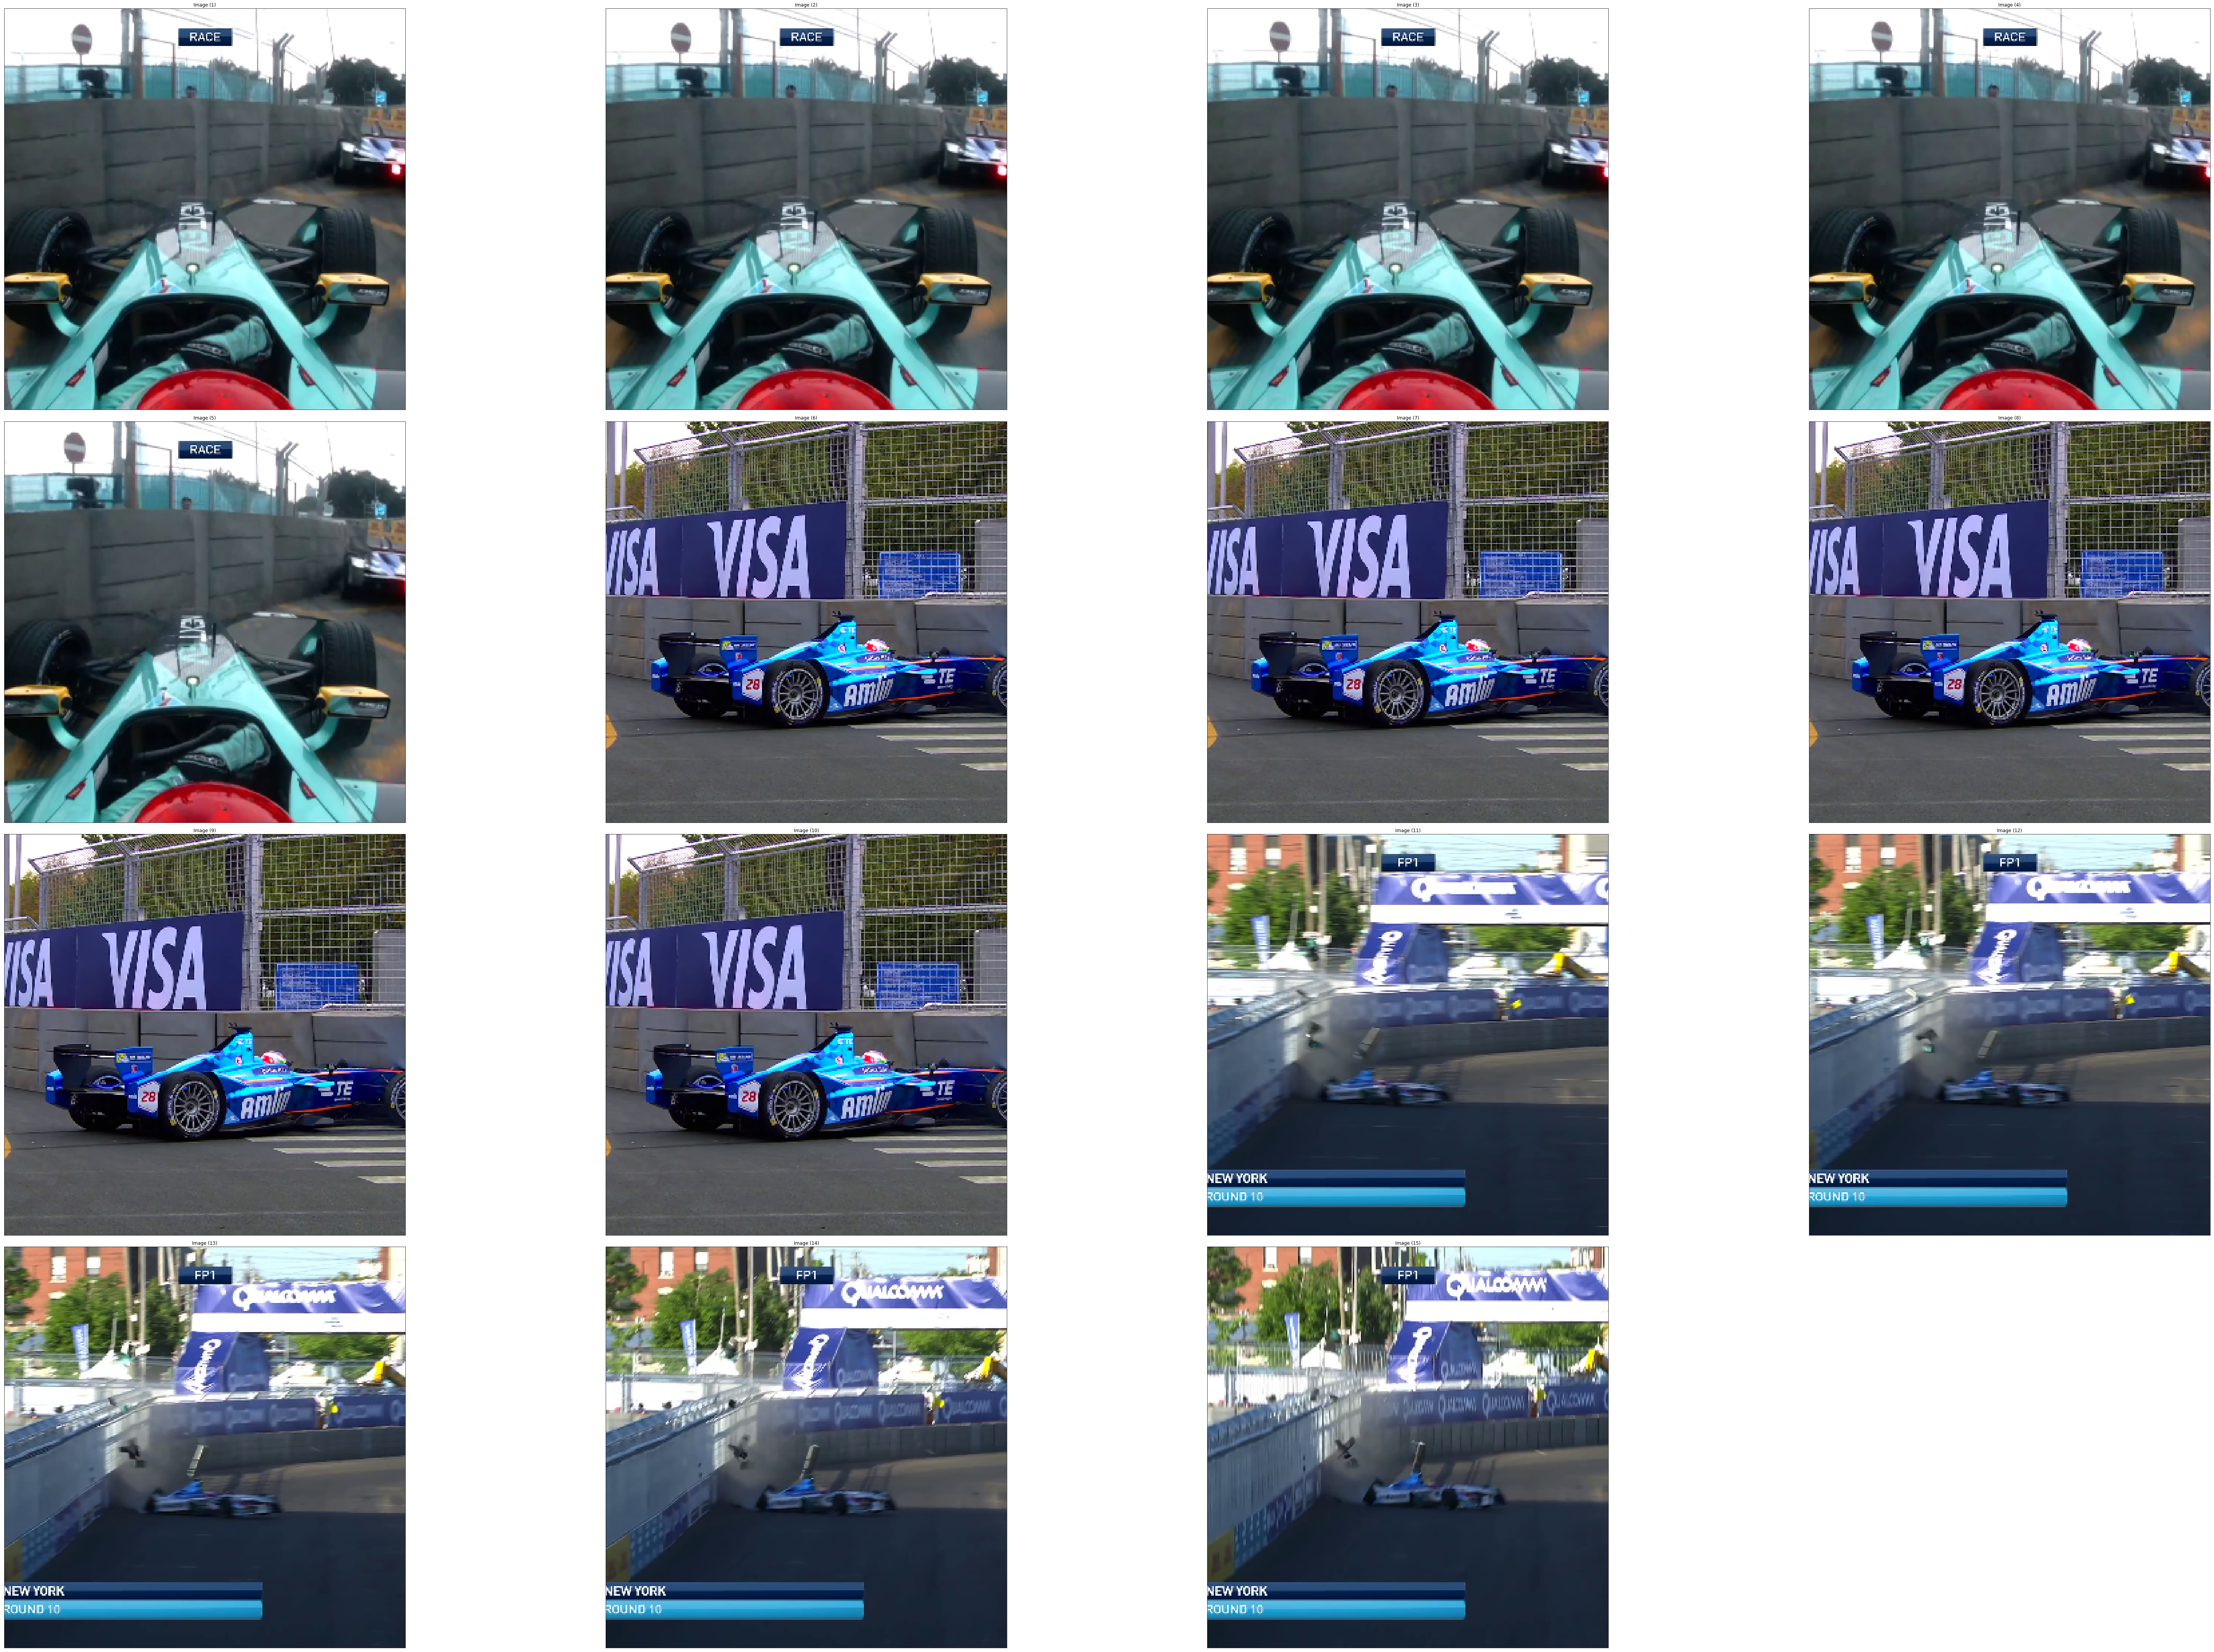

In [14]:
def getTestImages(flow, howmany=5):
    augmentedVideo = next(flow)
    print(augmentedVideo[2].shape)
    return range(augmentedVideo[2].shape[0]) \
        | select( lambda i: augmentedVideo[2][i] ) \
        | take(howmany) 


# show some augmented train images
images = getTestImages(train_flow)
for x in range(2):
    images = images | chain_with( getTestImages(train_flow) )

show_images( images | as_list, cols=4 )

# and do the same for some validation images
images = getTestImages(val_flow)
for x in range(2):
    images = images | chain_with( getTestImages(val_flow) )

show_images( images | as_list, cols=4 )

ok this is looking pretty good, next thing is to zeropad so that the number of frames is always the same i.e. max seconds * framerate

In [15]:
def zeroPadVideos(videoStream):
    for video in videoStream:
        zeroPadded = np.zeros( ( max_length * framerate, video_size, video_size, 3 ) )
        zeroPadded[ 0:video[2].shape[0], :, : ,: ] = video[2]
        yield video[:-1] + (zeroPadded,)

let's check that the framerate is indeed fixed

In [929]:
for x in range(3):
    assert( next( zeroPadVideos( train_flow ) )[2].shape[0]==max_length * framerate )

OK the next problem is we have a nice generator for videos, but we are doing a 4d CNN with videos and need a batch dimension, so let's write another generator which will batch X videos at a time

```
next( zeroPadVideos( flow ) )[3].shape
```
== (125, 200, 200, 3)


In [16]:
def getBatchVideosFlow(flow, batchsize):
    while(True):
        batch = np.zeros( (batchsize, max_length * framerate, video_size, video_size, 3 ) )
        labels = np.zeros( (batchsize,1))
        for i in range(batchsize):
            video = next( zeroPadVideos( flow ) )
            batch[i] = video[2]
            labels[i] = video[0]
        yield ( batch, labels )

We now have a generator giving us batches of training examples and respective labels, we can feed this into keras fit_generator!

In [17]:
from sys import getsizeof

r = next( getBatchVideosFlow( train_flow, 20 ) )
print(r[0].shape)
print(r[1].shape)

getsizeof(r[0])/1024**3
# == 2.4gb for 20 videos of 125 frames @ 200^2*3

# clear r
r=0

(20, 125, 300, 300, 3)
(20, 1)


5.029142051935196

now let's try and train keras on it

In [634]:
from keras import layers
from keras import models
from keras import regularizers

prelu = layers.advanced_activations.LeakyReLU(alpha=0.3)

model = models.Sequential()
model.add(layers.Conv3D(15, (1, 3, 3),
                        input_shape=(max_length * framerate, video_size, video_size, 3)))
model.add(prelu)
model.add(layers.AveragePooling3D((4, 2, 2)))
model.add(layers.Conv3D(32, (2, 3, 3) ))
model.add(prelu)
model.add(layers.AveragePooling3D((5, 2, 2)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(20))
model.add(prelu)
model.add(layers.Dense(20))
model.add(prelu)
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv3d_146 (Conv3D)          (None, 50, 46, 46, 15)    420       
_________________________________________________________________
leaky_re_lu_16 (LeakyReLU)   multiple                  0         
_________________________________________________________________
average_pooling3d_8 (Average (None, 12, 23, 23, 15)    0         
_________________________________________________________________
conv3d_147 (Conv3D)          (None, 11, 21, 21, 32)    8672      
_________________________________________________________________
average_pooling3d_9 (Average (None, 2, 10, 10, 32)     0         
_________________________________________________________________
flatten_67 (Flatten)         (None, 6400)              0         
_________________________________________________________________
dropout_60 (Dropout)         (None, 6400)              0         
__________

In [37]:
from keras import optimizers

diff_val = None

train_flow = videoFlowWithAugmentation(colpath='./train/collisions',noncolpath='./train/not-collisions', augment=True, diff=diff_val)
# remember, on validation we don't want to augment anything!
val_flow = videoFlowWithAugmentation(colpath='./val/collisions',noncolpath='./val/not-collisions', augment=False, diff=diff_val)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(lr=0.005),
              metrics=['acc'])

print('training with videosize: %s framerate: %d' % (video_size, framerate))

history = model.fit_generator(
      getBatchVideosFlow( train_flow, 20 ),
      steps_per_epoch=9, 
      validation_data=getBatchVideosFlow( val_flow, 10 ), 
      # has to be false on windows..
      use_multiprocessing=False, 
      validation_steps = 8,
      epochs=30)

training with videosize: 300 framerate: 25
Epoch 1/30


KeyboardInterrupt: 

Now we plot to see the convergence behaviour and overfitting

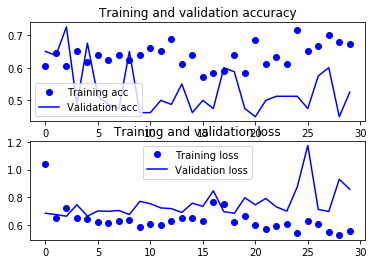

In [636]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


f, (ax1,ax2) = plt.subplots(2,1)

epochs = range(len(acc))

ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()


ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.show()


lets try using conv base as an input now

In [19]:
from keras.applications import VGG16

conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(video_size, video_size, 3))

conv_base.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 300, 300, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 300, 300, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 300, 300, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 150, 150, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 150, 150, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 150, 150, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 75, 75, 128)       0         
__________

add the conv base into a basic classifier 

Lets write a new generator which will give us embeddings of the frames in 2 dimensions 

In [25]:
from keras import optimizers
from functools import reduce

def getBatchVideoEmbeddingsFlow(flow, batchsize, color_channel=None):
    while(True):
        oshape = (batchsize, max_length * framerate, reduce(operator.mul, conv_base.output_shape[1:]) )
        if color_channel is True: oshape = oshape + (1,)
            
        batch = np.zeros( oshape )
        labels = np.zeros( (batchsize,1))
        for i in range(batchsize):
            video = next(zeroPadVideos( flow ))
            embedding = conv_base.predict( video[2] )
            embedding = embedding.reshape(oshape[1:])
            batch[i] = embedding
            labels[i] = video[0]
        yield ( batch, labels )

We can visualise the results

In [27]:
import operator

train_flow = videoFlowWithAugmentation(colpath='./train/collisions',noncolpath='./train/not-collisions', augment=True, diff=False)
batch = next(getBatchVideoEmbeddingsFlow(train_flow,5))


show_images( range(5) | select( lambda i: batch[0][i] ) | as_list, cols=4 )

IndexError: index 5 is out of bounds for axis 0 with size 5

now let's build a simple 2d cnn to take these as inputs

In [35]:
from keras import layers
from keras import models

model = models.Sequential()
model.add(layers.Conv2D(30, (3,1), activation='relu',
                        input_shape=(max_length * framerate, reduce(operator.mul, conv_base.output_shape[1:]), 1)))
model.add(layers.AveragePooling2D((5,5)))
model.add(layers.Conv2D(64, (3,2), activation='relu'))
model.add(layers.AveragePooling2D((2,10)))
model.add(layers.Conv2D(32, (3,2), activation='relu'))
model.add(layers.AveragePooling2D((2,10)))
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='sigmoid'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 123, 41472, 30)    120       
_________________________________________________________________
average_pooling2d_12 (Averag (None, 24, 8294, 30)      0         
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 22, 8293, 64)      11584     
_________________________________________________________________
average_pooling2d_13 (Averag (None, 11, 829, 64)       0         
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 9, 828, 32)        12320     
_________________________________________________________________
average_pooling2d_14 (Averag (None, 4, 82, 32)         0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 10496)             0         
__________

In [36]:
from keras import optimizers

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.Nadam(lr=0.005),
              metrics=['acc'])

diff_val = None

print('training with videosize: %s framerate: %d' % (video_size, framerate))

train_flow = videoFlowWithAugmentation(colpath='./train/collisions',noncolpath='./train/not-collisions', augment=True, diff=diff_val)
# remember, on validation we don't want to augment anything!
val_flow = videoFlowWithAugmentation(colpath='./val/collisions',noncolpath='./val/not-collisions', augment=False, diff=diff_val)

history = model.fit_generator(
      getBatchVideoEmbeddingsFlow(train_flow,5, color_channel=True),
      steps_per_epoch=4, 
      validation_data=getBatchVideoEmbeddingsFlow( val_flow, 10, color_channel=True ), 
      # has to be false on windows..
      use_multiprocessing=False, 
      validation_steps = 1,
      epochs=10)

training with videosize: 300 framerate: 25
Epoch 1/10


ResourceExhaustedError: OOM when allocating tensor with shape[5,30,123,41472] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[Node: training_1/Nadam/gradients/average_pooling2d_12/AvgPool_grad/AvgPoolGrad = AvgPoolGrad[T=DT_FLOAT, data_format="NCHW", ksize=[1, 1, 5, 5], padding="VALID", strides=[1, 1, 5, 5], _device="/job:localhost/replica:0/task:0/device:GPU:0"](training_1/Nadam/gradients/average_pooling2d_12/AvgPool_grad/Shape, training_1/Nadam/gradients/conv2d_13/convolution_grad/Conv2DBackpropInput)]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.


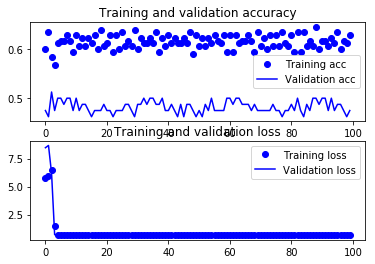

In [952]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']


f, (ax1,ax2) = plt.subplots(2,1)

epochs = range(len(acc))

ax1.plot(epochs, acc, 'bo', label='Training acc')
ax1.plot(epochs, val_acc, 'b', label='Validation acc')
ax1.set_title('Training and validation accuracy')
ax1.legend()


ax2.plot(epochs, loss, 'bo', label='Training loss')
ax2.plot(epochs, val_loss, 'b', label='Validation loss')
ax2.set_title('Training and validation loss')
ax2.legend()

plt.show()
